In [1]:
!pip install datasets
!pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate


In [26]:
def sentence_to_ngram(tokenized_sentence, n=3):
    """
    Funzione che restituisce tutti i n-grammi contenuti all'interno della frase tokenizzata.

    Args:
        tokenized_sentence: lista di parole/tokens che compongono la frase
        n: n-grammi da considerare

    Returns:
        lista di tutti i n-grammi presenti all'interno della frase tokenizzata
    """

    ngram_list = []
    for i in range(len(tokenized_sentence) - n + 1):
        # the sliding window starts at position i and contains 3 words
        ngram = tokenized_sentence[i : i + n]
        ngram_list.append(ngram)
    return ngram_list



Vediamo alcuni metodi che sono utilizzati per calcolare e valutare la qualità di un modello generativo!


# BLEU scores

È una metrica molto usata per calcolare le performances per task generativi soprattutto per Machine Translation (anche in questo caso, si basa sull'avere un testo - una risposta ottimale al problema di riferimento - da utilizzare come Golden Standard o Ground Truth).
Si mettono a confronto gli N-Grammi del testo di riferimento e del testo generato dal modello Generativo

Ti ricordo che il BLEU Score viene calcolato utilizzando questa formula:
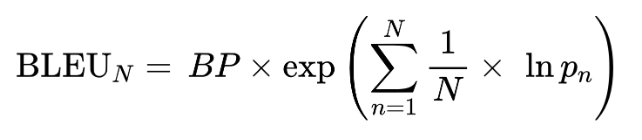

Proviamo a calcolare a mano la metrica utilizzando questi esempi:

In [52]:
candidate = "The cat is on the table"
reference_1 = "The cat is on the mat"
reference_2 = "There is a cat on the mat"

max_order=4

Calcoliamo la precision dei token del nostro candidate rispetto ai token della prima reference

N=1

In [53]:
total_unigrams_candidate = len(candidate.split())
n_overlapping_unigrams_reference_1 = len([x for x in candidate.split() if x in reference_1.split()])
precision_unigram_reference_1 = n_overlapping_unigrams_reference_1 / total_unigrams_candidate
print(precision_unigram_reference_1)

0.8333333333333334


N=2

In [54]:
candidate_bigrams = sentence_to_ngram(candidate.split(), 2)
print(candidate_bigrams)

reference_1_bigrams = sentence_to_ngram(reference_1.split(), 2)
print(reference_1_bigrams)

total_bigrams_candidate = len(candidate_bigrams)
n_overlapping_bigrams_reference_1 = len([x for x in candidate_bigrams if x in reference_1_bigrams])
precision_bigram_reference_1 = n_overlapping_bigrams_reference_1 / total_bigrams_candidate
print(precision_bigram_reference_1)

[['The', 'cat'], ['cat', 'is'], ['is', 'on'], ['on', 'the'], ['the', 'table']]
[['The', 'cat'], ['cat', 'is'], ['is', 'on'], ['on', 'the'], ['the', 'mat']]
0.8


Scriviamo ora una funzione che calcola la precision per tutti i N-Gram del nostro candidate

In [55]:
def compute_token_precision(candidate, reference, max_order=4):
  precision_list = []
  total_unigrams_candidate = len(candidate.split())
  n_overlapping_unigrams_reference_1 = len([x for x in candidate.split() if x in reference.split()])
  precision_list.append(n_overlapping_unigrams_reference_1 / total_unigrams_candidate)

  max_ngrams = min(max_order, total_unigrams_candidate)

  for n in range(2, max_ngrams+1):
    candidate_ngrams = sentence_to_ngram(candidate.split(), n)
    reference_ngrams = sentence_to_ngram(reference.split(), n)
    total_ngrams_candidate = len(candidate_ngrams)
    n_overlapping_ngrams_reference_1 = len([x for x in candidate_ngrams if x in reference_ngrams])
    precision_list.append(n_overlapping_ngrams_reference_1 / total_ngrams_candidate)
  return precision_list


In [66]:
pr_list = compute_token_precision(candidate, reference_1)
print(pr_list)

[0.8333333333333334, 0.8, 0.75, 0.6666666666666666]


Calcoliamo la brevity penalty

In [62]:
bp = 1 if len(candidate.split())>=len(reference_1.split()) else np.exp(1-((len(reference_1.split()))/len(candidate)))

Applichiamo ora la formula

In [67]:
BLEU4 = bp * np.exp(sum([np.log(x)/(max_order) if x !=0 else 0 for x in pr_list]))
BLEU4

0.7598356856515925

Calcoliamo ora il BLEU score rispetto alla reference 2

In [58]:
pr_list = compute_token_precision(candidate, reference_2)
print(pr_list)

[0.6666666666666666, 0.2, 0.0, 0.0]


In questo caso, siccome alcune precision sono 0, lo score BLEU diventa automaticamente 0! (non é impossibile calcolare il logaritmo di 0)

Calcoliamo ora il BLEU score utilizzando la funzione nella libreria 'evaluate' di HuggingFace

In [68]:
bleu = evaluate.load("bleu")

In [69]:
bleu.compute(predictions=[candidate], references=[reference_1])

{'bleu': 0.7598356856515925,
 'precisions': [0.8333333333333334, 0.8, 0.75, 0.6666666666666666],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0,
 'translation_length': 6,
 'reference_length': 6}

In [70]:
bleu.compute(predictions=[candidate], references=[reference_2])

{'bleu': 0.0,
 'precisions': [0.6666666666666666, 0.2, 0.0, 0.0],
 'brevity_penalty': 0.846481724890614,
 'length_ratio': 0.8571428571428571,
 'translation_length': 6,
 'reference_length': 7}